In [19]:
import numpy as np
import nengo
import nengolib
import matplotlib.pyplot as plt
import seaborn as sns

from nengolib.signal import s
from nengolib.synapses import Lowpass
from nengo_bioneurons import BahlNeuron, build_filter
from nengo.utils.matplotlib import rasterplot
sns.set(context='poster', style='whitegrid')


In [20]:
class LearningNode(nengo.Node):
    def __init__(self,
                 conn,
                 n_syn,
                 dim,
                 d_pre,
                 e_bio,
                 g_bio,
                 d_bio,
                 learning_rate,
                 learning_seed=6):
        self.conn = conn
        self.n_syn = n_syn
        self.dim = dim
        self.d_pre = d_pre
        self.e_bio = e_bio
        self.g_bio = g_bio
        self.d_bio = d_bio
        self.learning_rate = learning_rate
        self.rng = np.random.RandomState(seed=learning_seed)
        # weight update retrieved in builder's transmit_spikes 
        self.delta_weights = np.zeros((
            self.d_bio.shape[0], self.d_pre.shape[0], self.n_syn))
        super(LearningNode, self).__init__(self.update, 
                                           size_in=2*self.dim,
                                           size_out=None)
                                           # size_out=self.e_bio.shape[0])
    def update(self, t, x):  # assume 1D for now
        if not self.learning_rate > 0.0:
            return
        # x[:dim] is bio, x[dim:2*dim] is target
        # self.syn_weights[i, pre, syn] = np.dot(d_pre.T[pre], g_bio[i] * e_bio[i])  # keeps weights the same
        error = x[:self.dim] - x[self.dim: 2*self.dim]
        for i in range(self.d_bio.shape[0]):
            if error < 0.0:
                if self.d_bio[i] < 0.0:
                    # bioneuron_i is overactive, must reduce input current by lowering weight
                    for pre in range(self.d_pre.shape[0]):
                        for syn in range(self.n_syn):
                            self.delta_weights[i, pre, syn] = error * self.rng.uniform(0, self.learning_rate)
                elif self.d_bio[i] > 0.0:
                    # bioneuron_i is underactive, must increase input current by increasing weight
                    for pre in range(self.d_pre.shape[0]):
                        for syn in range(self.n_syn):
                            self.delta_weights[i, pre, syn] = -error * self.rng.uniform(0, self.learning_rate)
            elif error > 0.0:
                if self.d_bio[i] < 0.0:
                    # bioneuron_i is underactive, must increase input current by increasing weight
                    for pre in range(self.d_pre.shape[0]):
                        for syn in range(self.n_syn):
                            self.delta_weights[i, pre, syn] = error * self.rng.uniform(0, self.learning_rate)
                elif self.d_bio[i] > 0.0:
                    # bioneuron_i is overactive, must decrease input current by lowering weight
                    for pre in range(self.d_pre.shape[0]):
                        for syn in range(self.n_syn):
                            self.delta_weights[i, pre, syn] = -error * self.rng.uniform(0, self.learning_rate)
        return

In [64]:
def train(
    n=100,
    tau=0.1,
    reg_init=1.0,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    secs=['apical'],
    n_syns=[1],
    signal='cos',
    freq=5*np.pi,
    t=1.0,
    es=0,
    cs=1,
    ss=2,
    verbose=False,
):
    
    # first find the norm of the filtered signal
    lpf=nengo.Lowpass(tau)
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral])
    target_ff = lpf.filt(lpf.filt(sim.data[p_integral]))
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    norm_ff = np.max(np.abs(target_ff))

    # now calculate readout decoders for "bio", which will also be used to
    # initialize the recurrent matrix
    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=100,
                high=freq,
                rms=0.5,
                seed=ss))
        pre = nengo.Ensemble(n, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
        lif = nengo.Ensemble(n, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
        bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())       
        nengo.Connection(stim, pre, synapse=1/s)
        for j, sec in enumerate(secs):
            nengo.Connection(pre, bio,
                             sec=sec,
                             n_syn=n_syns[j],
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             transform=1.0/norm_ff,
                             seed=cs)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_ff)
        pre_lif = nengo.Connection(pre, lif, synapse=None)  # to extract pre_out decoders
        p_act = nengo.Probe(bio.neurons, synapse=None)
        p_target = nengo.Probe(tar, synapse=None)     
    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)
    act_f = lpf.filt(sim.data[p_act])
    target_ff = lpf.filt(lpf.filt(sim.data[p_target]))
    d_init = nengo.solvers.LstsqL2(reg=reg_init)(act_f, target_ff)[0]
    xhat_init = np.dot(act_f, d_init)
    e_init = nengolib.signal.nrmse(xhat_init, target_ff)
    d_pre = sim.data[pre_lif].weights.T
    
    if verbose:
        plt.figure()
        plt.title(r"feedforward decode $\Longrightarrow$ NRMSE=%.3f" %e_init)
        plt.plot(sim.trange(), target_ff, label=r"$x$", linestyle='--')
        plt.plot(sim.trange(), xhat_init, label=r"$\hat{x}$")
        plt.legend()
        plt.show()
        fig, ax = plt.subplots(1, 1, figsize=(6,8))
        plt.title(r"feedforward spikes")
        rasterplot(sim.trange(), sim.data[p_act], ax=ax)
        plt.show()
        
    return d_init, norm_s, norm_f, norm_ff, d_pre_out

Get the readout decoders and normalization factors for a feedforward bioneuron network stimulated with an integrated cos(t) or white_noise signal.

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


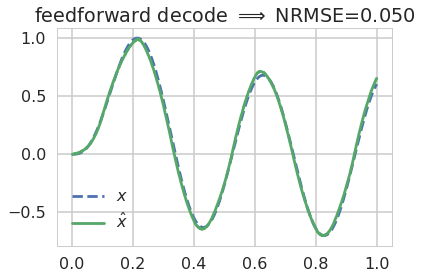

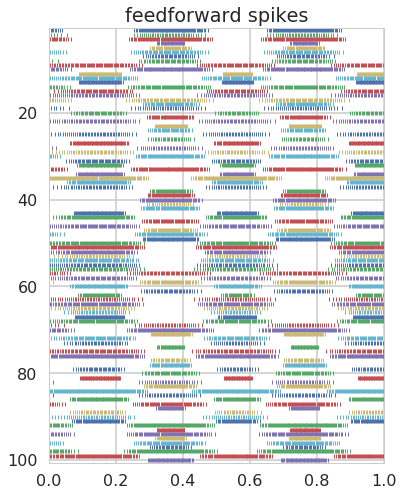

In [65]:
d_init, norm_s, norm_f, norm_ff, d_pre = train(reg_init=0.1, verbose=True)

Now run the full simulations with the appropriate normalizing transforms

In [66]:
def learn(
    d_init=np.zeros((100, 1)),
    n=100,
    tau=0.1,
    reg_init=1.0,
    learning_rate=1e-10,
    d_pre=np.zeros((100, 1)),
    e_bio=None,
    g_bio=None,
    syn_weights=None,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    secs=['apical'],
    n_syns=[1],
    signal='cos',
    freq=5*np.pi,
    norm_f=1,
    norm_ff=1,
    t=1.0,
    es=0,
    cs=1,
    ss=2,
    ls=3,
    verbose=False):

    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=100,
                high=freq,
                rms=0.5,
                seed=ss))
        pre = nengo.Ensemble(n, 1, radius=norm_s, neuron_type=nengo.LIF(), seed=es)
        bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)

        p_bios = []
        nengo.Connection(stim, pre, synapse=None)
        for j, sec in enumerate(secs):
            nengo.Connection(pre, bio,
                             sec=sec,
                             n_syn=n_syns[j],
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             transform=tau/norm_f,
                             seed=cs)
            bio_bio = nengo.Connection(bio, bio,
                             sec=sec,
                             n_syn=n_syns[j],
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             solver=nengo.solvers.NoSolver(d_init),
                             seed=cs,
                             syn_weights=syn_weights)
            if learning_rate > 0.0:
                learning_node = LearningNode(conn=bio_bio,
                                             n_syn=n_syns[j],
                                             d_pre=d_pre,
                                             e_bio=e_bio,
                                             g_bio=g_bio,
                                             d_bio=d_init,
                                             learning_rate=learning_rate,
                                             learning_seed=ls)
                bio_bio.learning_node = learning_node
                bio_node = nengo.Connection(bio, learning_node[:dim],
                    synapse=tau,
                    solver=nengo.solvers.NoSolver(d_init))
                target_node = nengo.Connection(tar, learning_node[dim:2*dim],
                    synapse=tau)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f)

        p_act = nengo.Probe(bio.neurons, synapse=None)
        p_bio = nengo.Probe(bio, synapse=tau, solver=nengo.solvers.NoSolver(d_init))
        p_target = nengo.Probe(tar, synapse=tau)
        
    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)

    target = sim.data[p_target]
    xhat = sim.data[p_bio]
    e = nengolib.signal.nrmse(xhat, target=target)
    
    plt.figure()
    plt.title("feedback decode \nlearning rate %s \nNRMSE=%.3f" %(learning_rate, e))
    plt.plot(sim.trange(), target, label=r"$x$", linestyle='--')
    plt.plot(sim.trange(), xhat, label=r"$\hat{x}$")
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 8))
    plt.title("feedback spikes")
    rasterplot(sim.trange(), sim.data[p_act], ax=ax)
    plt.show()

In [67]:
learn(d_init=d_init, norm_f=norm_f, verbose=True)

TypeError: __init__() takes at least 9 arguments (9 given)

In [53]:
def test(
    d_final=np.zeros((100, 1)),
    n=100,
    tau=0.1,
    reg_init=1.0,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    secs=['apical'],
    n_syns=[1],
    signal='cos',
    freq=5*np.pi,
    norm_f=1,
    norm_ff=1,
    t=1.0,
    es=0,
    cs=1,
    ss=2,
    verbose=False):

    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=100,
                high=freq,
                rms=0.5,
                seed=ss))
        pre = nengo.Ensemble(n, 1, radius=norm_s, neuron_type=nengo.LIF(), seed=es)
        bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)

        p_bios = []
        nengo.Connection(stim, pre, synapse=None)
        for j, sec in enumerate(secs):
            nengo.Connection(pre, bio,
                             sec=sec,
                             n_syn=n_syns[j],
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             transform=tau/norm_f,
                             seed=cs)
            nengo.Connection(bio, bio,
                             sec=sec,
                             n_syn=n_syns[j],
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             solver=nengo.solvers.NoSolver(d_final),
                             seed=cs)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f)

        p_act = nengo.Probe(bio.neurons, synapse=None)
        p_bio = nengo.Probe(bio, synapse=tau, solver=nengo.solvers.NoSolver(d_final))
        p_target = nengo.Probe(tar, synapse=tau)
        
    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)

    target = sim.data[p_target]
    xhat = sim.data[p_bio]
    e = nengolib.signal.nrmse(xhat, target=target)
    
    plt.figure()
    plt.title(r"feedback decode $\Longrightarrow$ NRMSE=%.3f" %e)
    plt.plot(sim.trange(), target, label=r"$x$", linestyle='--')
    plt.plot(sim.trange(), xhat, label=r"$\hat{x}$")
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 8))
    rasterplot(sim.trange(), sim.data[p_act], ax=ax)
    plt.show()

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


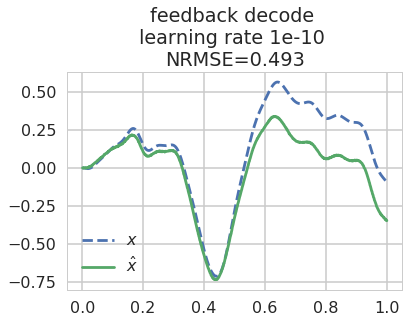

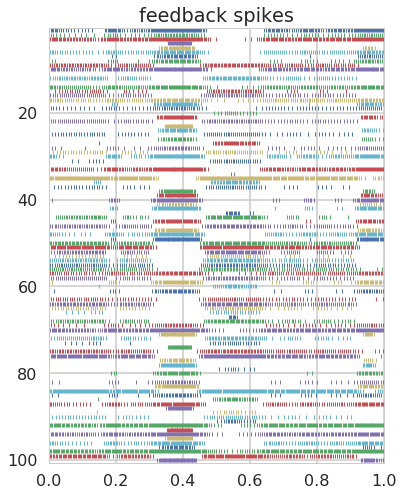

In [54]:
learn(signal='white_noise', d_init=d_init, norm_f=norm_f, verbose=True)